# MadMiner particle physics tutorial

# Part 2b: Analyzing events at Delphes level

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this second part of the tutorial, we'll generate events and extract the observables and weights from them. You have two options: In this notebook we'll do this with Delphes, in the alternative part 2a we stick to parton level.

## 0. Preparations

Before you execute this notebook, make sure you have working installations of MadGraph, Pythia, and Delphes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.delphes import DelphesReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [3]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_5'

## 1. Generate events

Let's load our setup:

In [4]:
miner = MadMiner()
miner.load("data/setup.h5")

12:09 madminer.core        INFO    Found 2 parameters:
12:09 madminer.core        INFO       CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
12:09 madminer.core        INFO       CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 10.0))
12:09 madminer.core        INFO    Found 6 benchmarks:
12:09 madminer.core        INFO       sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
12:09 madminer.core        INFO       w: CWL2 = 10.00, CPWL2 = 0.00e+00
12:09 madminer.core        INFO       morphing_basis_vector_2: CWL2 = 7.51, CPWL2 = -9.40e+00
12:09 madminer.core        INFO       morphing_basis_vector_3: CWL2 = -8.88e+00, CPWL2 = -5.37e+00
12:09 madminer.core        INFO       morphing_basis_vector_4: CWL2 = -7.84e+00, CPWL2 = 7.55
12:09 madminer.core        INFO       morphing_basis_vector_5: CWL2 = -3.97e+00, CPWL2 = -9.54e+00
12:09 madminer.core        INFO    Found morphing setup with 6 components
12:09 madminer.core        INFO    Did not find syste

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You can use `run()` or `run_multiple()`; the latter allows to generate different runs with different run cards and optimizing the phase space for different benchmark points. 

In either case, you have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` (or in the case of `run_all`, `sample_benchmarks`) option can be used to specify which benchmark should be used for sampling, i.e. for which benchmark point the phase space is optimized. If you just use one benchmark, reweighting to far-away points in parameter space can lead to large event weights and thus large statistical fluctuations. It is therefore often a good idea to combine at least a few different benchmarks for this option. Here we use the SM and the benchmark "w" that we defined during the setup step.

One slight annoyance is that MadGraph only supports Python 2. The `run()` and `run_multiple()` commands have a keyword `initial_command` that let you load a virtual environment in which `python` maps to Python 2 (which is what we do below). Alternatively / additionally you can set `python2_override=True`, which calls `python2.7` instead of `python` to start MadGraph.

In [5]:
miner.run_multiple(
    sample_benchmarks=['sm', 'w'],
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal_pythia',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    run_card_files=['cards/run_card_signal.dat'],
    log_directory='logs/signal',
    initial_command="source activate python2"
)

12:09 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal_pythia
12:09 madminer.core        INFO    Run 0
12:09 madminer.core        INFO      Sampling from benchmark: sm
12:09 madminer.core        INFO      Original run card:       cards/run_card_signal.dat
12:09 madminer.core        INFO      Original Pythia8 card:   cards/pythia8_card.dat
12:09 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
12:09 madminer.core        INFO      Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
12:09 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
12:09 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
12:09 madminer.core        INFO      Log file:                run_0.log
12:09 madminer.core        INFO    Creating param and reweight cards in ./mg_processes/signal_pythia//madminer/cards/param_card_0.da

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

### Backgrounds

We can also easily add other processes like backgrounds. An important option is the `is_background` keyword, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [6]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background_pythia',
    proc_card_file='cards/proc_card_background.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

u"\nminer.run(\n    is_background=True,\n    sample_benchmark='sm',\n    mg_directory=mg_dir,\n    mg_process_directory='./mg_processes/background_pythia',\n    proc_card_file='cards/proc_card_background.dat',\n    pythia8_card_file='cards/pythia8_card.dat',\n    param_card_template_file='cards/param_card_template.dat',\n    run_card_file='cards/run_card_background.dat',\n    log_directory='logs/background',\n)\n"

Finally, note that both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 2. Run Delphes

The `madminer.delphes.DelphesReader` class wraps around Delphes, a popular fast detector simulation, to simulate the effects of the detector.

In [4]:
delphes = DelphesReader('data/setup.h5')

After creating the `DelphesReader` object, one can add a number of event samples (the output of running MadGraph and Pythia in step 1 above) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [5]:
delphes.add_sample(
    lhe_filename='mg_processes/signal_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1.1,
)
delphes.add_sample(
    lhe_filename='mg_processes/signal_pythia/Events/run_02/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/signal_pythia/Events/run_02/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='w',
    is_background=False,
    k_factor=1.1,
)

"""
delphes.add_sample(
    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""


u"\ndelphes.add_sample(\n    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',\n    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',\n    sampled_from_benchmark='sm',\n    is_background=True,\n    k_factor=1.0,\n"

Now we run Delphes on these samples (you can also do this externally and then add the keyword `delphes_filename` when calling `DelphesReader.add_sample()`):

In [6]:
delphes.run_delphes(
    delphes_directory=mg_dir + '/Delphes',
    delphes_card='cards/delphes_card.dat',
    log_file='logs/delphes.log',
)

14:01 madminer.delphes     INFO    Running Delphes on HepMC sample at mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
14:03 madminer.delphes     INFO    Running Delphes on HepMC sample at mg_processes/signal_pythia/Events/run_02/tag_1_pythia8_events.hepmc.gz


## 3. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [7]:
delphes.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=0.,
)
delphes.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=True,
)
delphes.add_observable(
    'met',
    'met.pt',
    required=True,
)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [8]:
delphes.add_cut('(a[0] + a[1]).m > 122.')
delphes.add_cut('(a[0] + a[1]).m < 128.')
delphes.add_cut('pt_j1 > 20.')

## 4. Analyse events and store data

The function `analyse_samples` then calculates all observables from the Delphes file(s) generated before and checks which events pass the cuts:

In [9]:
delphes.analyse_delphes_samples()

14:08 madminer.delphes     INFO    Analysing Delphes sample mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root
14:09 madminer.utils.inter INFO      21385 / 50000 events pass everything
14:09 madminer.delphes     INFO    Analysing Delphes sample mg_processes/signal_pythia/Events/run_02/tag_1_pythia8_events_delphes.root
14:10 madminer.utils.inter INFO      18135 / 50000 events pass everything


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [10]:
delphes.save('data/delphes_data.h5')

## 5. Plot distributions

Let's see what our MC run produced:

14:10 madminer.analysis    INFO    Loading data from data/delphes_data.h5
14:10 madminer.analysis    INFO    Found 2 parameters
14:10 madminer.analysis    INFO    Did not find nuisance parameters
14:10 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
14:10 madminer.analysis    INFO    Found 3 observables
14:10 madminer.analysis    INFO    Found 39520 events
14:10 madminer.analysis    INFO    Found morphing setup with 6 components


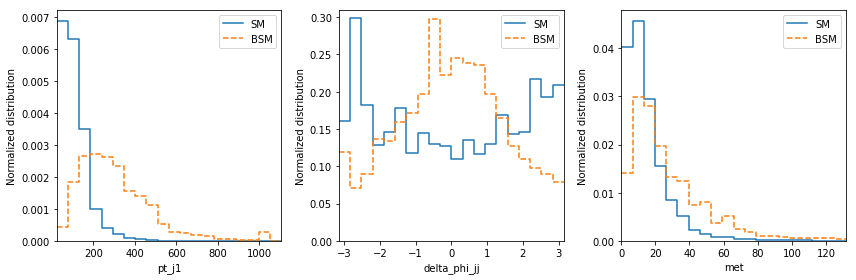

In [11]:
_ = plot_distributions(
    filename='data/delphes_data.h5',
    parameter_points=['sm', np.array([10.,0.])],
    line_labels=['SM', 'BSM'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 6. Combine and shuffle different samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

This is generally good practice even if you use just one sample, since the events might have some inherent ordering (e.g. from sampling from different hypotheses). Later when we split the events into a training and test fraction, such an ordering could cause problems.

In [12]:
combine_and_shuffle(
    ['data/delphes_data.h5'],
    'data/delphes_data_shuffled.h5'
)

14:10 madminer.sampling    INFO    Copying setup from data/delphes_data.h5 to data/delphes_data_shuffled.h5
14:10 madminer.sampling    INFO    Loading samples from file 1 / 1 at data/delphes_data.h5, multiplying weights with k factor 1.0
